**Validation Metrics**

This notebook accepts a trained model and outputs statistics of its performance.

* Performance on training, validation, and test set
* Plot our predictions versus assay output
* Overlap with conservation scores
* Overlap with CENTIPEDE motifs
* Scatter plot of our importance scores versus SHARPR scores
* ... Things I missed :)

**General Strategy for Importance Scores**

Let's try to get all types of importance scores into  nested dictionaries of the following spec:

(promoter, cell_type) -> chromosome -> position -> score


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Load in Experimental Data and SHARPR Predictions

In [2]:
# This loads in the experimental data
from mrpa_data import MrpaData
data = MrpaData()

mrpa_data.py:115: UserWarning: Replacing 'N' bases in seq with 'A' in seq NNNNNNNNNGATCCCGCGGCCGTGTTTTCCTGGTGGCCCGGCCGTGCCTGAGGTTTCTCCCCGAGCCGCCGCCTCTGCGGGCTCCCGGGTGCCCTTGCCCTCACGGTCCCCGGCCCTCGCCCGTCTGTGCCCTCTTCCCCGCCCG.
  warn("Replacing 'N' bases in seq with 'A' in seq {}.".format(seq))
mrpa_data.py:115: UserWarning: Replacing 'N' bases in seq with 'A' in seq NNNNGATCCCGCGGCCGTGTTTTCCTGGTGGCCCGGCCGTGCCTGAGGTTTCTCCCCGAGCCGCCGCCTCTGCGGGCTCCCGGGTGCCCTTGCCCTCACGGTCCCCGGCCCTCGCCCGTCTGTGCCCTCTTCCCCGCCCGCCGCC.
  warn("Replacing 'N' bases in seq with 'A' in seq {}.".format(seq))
mrpa_data.py:115: UserWarning: Replacing 'N' bases in seq with 'A' in seq NNNNNNNNNNNNNNNNNNGAATTCAATGGAGTGGACTGGAGTGCTGTGGGGTGGAGTGGAATGGAGTGTAGTTGAATGGAGTGGAATGGAATGCGATGGAATGGAGTGGAGTTGAGCAGAGTGAAGTGGAAAGGTGTAGAATGGA.
  warn("Replacing 'N' bases in seq with 'A' in seq {}.".format(seq))
mrpa_data.py:115: UserWarning: Replacing 'N' bases in seq with 'A' in seq NNNNNNNNNNNNNGAATTCAATGGAGTGGACTGGAGTGCTGTGGGGTGGAGTGGAA

In [3]:
# Loads in SHARPR activity scores
sharpr = {}
for promoter in data.promoters:
    for cell_type in data.cell_types:
        experiment_key = (promoter, cell_type)
        sharpr[experiment_key] = {}
        with open("../data/sharpr_scores/wig/{}_{}.wig".format(promoter, cell_type)) as wig:
            for line in wig:
                if line[0] == '#': continue
                chrom, start, end, score = line.strip().split()
                start, end = int(start), int(end)
                score = float(score)
                if end - start > 1: continue
                if chrom not in sharpr[experiment_key]: sharpr[experiment_key][chrom] = {}
                for pos in range(start, end):
                    assert pos not in sharpr[experiment_key][chrom]
                    sharpr[experiment_key][chrom][pos] = score

# Make Predictions from trained model

In [27]:
model = load_model() ####

predictions = {} # experiment -> chrom -> pos -> score
activity = {}    # experiment -> chrom -> pos -> deeplift / ism score
for position in positions:
    seq = get_seq(*position)  ###
    deeplift = get_deeplift(seq) ####

NameError: name 'load_model' is not defined

Our predictions versus assay output

# Conservation Analysis

Using SiPhi scores obtained from: https://www.broadinstitute.org/mammals-models/29-mammals-project-supplementary-info

My understanding is that for each 12mer in the genome, they assessed the extent of conservation accross 29 mamalian genomes. They then reported 12mers at a FDR of 10%.

See the below plot for the quantile analysis.

I tried simply making a scatter plot and boxplot of the data, but it was a mess.

In [5]:
# Load in the data.
si_phi = {} # chrom, position, LOR (no entry implies not signiticant)
with open('../data/conservation/hg19_29way_pi_lods_elements_12mers.chr_specific.fdr_0.1_with_scores.txt') as conservation:
    for line in conservation:
        chrom, start, end, lor, branch = line.strip().split()
        start, end, lor = int(start), int(end), float(lor)
        if chrom not in si_phi: si_phi[chrom] = {}
        for pos in range(start, end):
            si_phi[chrom][pos] = lor

In [6]:
for experiment, scores in sharpr.items():
    mrpa_conserve = []
    for chrom in scores:
        for pos in scores[chrom]:
            mrpa_conserve.append((scores[chrom][pos], si_phi[chrom][pos] if pos in si_phi[chrom] else 0))
    break

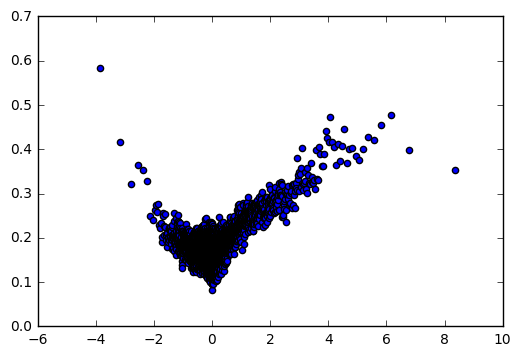

In [7]:
def quantile_plot(data_pairs):
    data_pairs = sorted(data_pairs, key = lambda x: x[0])
    avg_activity, avg_score = [], []
    quantiles = 5000
    for i in range(0, len(data_pairs), len(data_pairs) / quantiles):
        index = range(i, min(i + (len(data_pairs) / quantiles), len(data_pairs)))
        activities = [data_pairs[j][0] for j in index]
        scores  = [bool(data_pairs[j][1]) for j in index]
    
        avg_activity.append(sum(activities) / float(len(activities)))
        avg_score.append(sum(scores) / float(len(scores)))
    plt.scatter(avg_activity, avg_score)
    plt.show()
    
quantile_plot(mrpa_conserve)
        

# Motif Overlaps

In [31]:
hepG2_centipede = {}
with open('../data/centipede/HEPG2_liftover.bed') as regions:
    regions.readline()
    for line in regions:
        chrom, start, end = line.strip().split()[:3]
        start, end = int(start), int(end)
        if chrom not in hepG2_centipede:hepG2_centipede[chrom] = {}
        for pos in range(start, end):
            hepG2_centipede[chrom][pos] = 1

k562_centipede = {}
with open('../data/centipede/K562_liftover.bed') as regions:
    regions.readline()
    for line in regions:
        chrom, start, end = line.strip().split()[:3]
        start, end = int(start), int(end)
        if chrom not in k562_centipede: k562_centipede[chrom] = {}
        for pos in range(start, end):
            k562_centipede[chrom][pos] = 1       

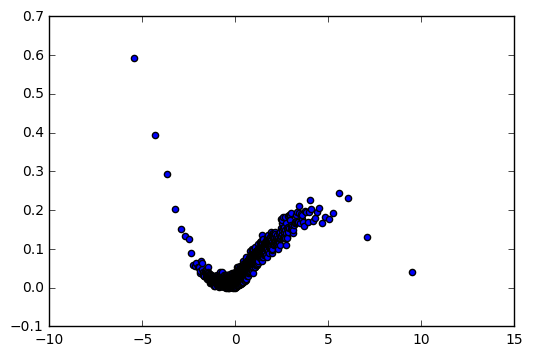

In [32]:
hepG2_pairs = []
for chrom, positions in sharpr[('SV40P', 'HepG2')].items():
    for pos, score in positions.items():
        hepG2_pairs.append((score, 1 if pos in hepG2_centipede[chrom] else 0))
quantile_plot(hepG2_pairs)